In [1]:
import matplotlib.pyplot as plt
import numpy as np
import open_clip
import torch
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
import time

/opt/anaconda3/envs/deepbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

batch_size = 64
num_batches = 10


In [3]:
# Hugging Face CLIP
hf_model_key = "openai/clip-vit-large-patch14"
print(f"Loading Hugging Face CLIP model: {hf_model_key}")
hf_model = CLIPModel.from_pretrained(hf_model_key).to(device)
hf_processor = CLIPProcessor.from_pretrained(hf_model_key)

Loading Hugging Face CLIP model: openai/clip-vit-large-patch14


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# OpenCLIP
open_clip_trainmodel_name = "ViT-L-14"
open_clip_pretraining_name = "openai"
print(f"Loading OpenCLIP model: {open_clip_trainmodel_name} with pretraining: {open_clip_pretraining_name}")
openclip_model, _, openclip_preprocess = open_clip.create_model_and_transforms(open_clip_trainmodel_name, pretrained=open_clip_pretraining_name)
openclip_model = openclip_model.to(device)
tokenizer = open_clip.get_tokenizer(open_clip_trainmodel_name)

Loading OpenCLIP model: ViT-L-14 with pretraining: openai


/opt/anaconda3/envs/deepbench/lib/python3.11/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [5]:
# Load CIFAR-10
_, preprocess, _ = open_clip.create_model_and_transforms(open_clip_trainmodel_name, pretrained=open_clip_pretraining_name)
testset = CIFAR10(root="./data", train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
class_names = testset.classes

Files already downloaded and verified


In [6]:
# Prepare text embeddings
with torch.no_grad():
    # Hugging Face
    text_inputs_hf = hf_processor(text=class_names, return_tensors="pt", padding=True).to(device)
    text_features_hf = hf_model.get_text_features(**text_inputs_hf)
    text_features_hf /= text_features_hf.norm(dim=-1, keepdim=True)

    # OpenCLIP
    text_inputs_oc = tokenizer(class_names).to(device)
    text_features_oc = openclip_model.encode_text(text_inputs_oc)
    text_features_oc /= text_features_oc.norm(dim=-1, keepdim=True)

In [7]:
# limit batch number - but evaluate on the exact same batches
limited_batches = []
for batch_idx, batch in enumerate(testloader):
    if batch_idx >= num_batches:
        break
    limited_batches.append(batch)

In [8]:
# Hugging Face Evaluation
y_true_hf, y_pred_hf = [], []
start_hf = time.time()

for images, labels in tqdm(limited_batches, "Hugging Face Inference"):
    y_true_hf.extend(labels.numpy())

    pil_images = [transforms.ToPILImage()(img.cpu()) for img in images]
    with torch.no_grad():
        inputs_hf = hf_processor(images=pil_images, return_tensors="pt", padding=True).to(device)
        image_features_hf = hf_model.get_image_features(**inputs_hf)
        image_features_hf /= image_features_hf.norm(dim=-1, keepdim=True)
        similarity_hf = image_features_hf @ text_features_hf.T
        preds_hf = similarity_hf.argmax(dim=1).cpu().numpy()
        y_pred_hf.extend(preds_hf)

elapsed_hf = time.time() - start_hf
acc_hf = (np.array(y_true_hf) == np.array(y_pred_hf)).mean() * 100

Hugging Face Inference: 100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


In [ ]:
# OpenCLIP Evaluation
y_true_oc, y_pred_oc = [], []
start_oc = time.time()

for images, labels in tqdm(limited_batches, "OpenCLIP Inference"):
    y_true_oc.extend(labels.numpy())

    images_oc = images.to(device)
    with torch.no_grad():
        image_features_oc = openclip_model.encode_image(images_oc)
        image_features_oc /= image_features_oc.norm(dim=-1, keepdim=True)
        similarity_oc = image_features_oc @ text_features_oc.T
        preds_oc = similarity_oc.argmax(dim=1).cpu().numpy()
        y_pred_oc.extend(preds_oc)

elapsed_oc = time.time() - start_oc
acc_oc = (np.array(y_true_oc) == np.array(y_pred_oc)).mean() * 100

OpenCLIP Inference:  80%|████████  | 8/10 [00:29<00:07,  3.71s/it]

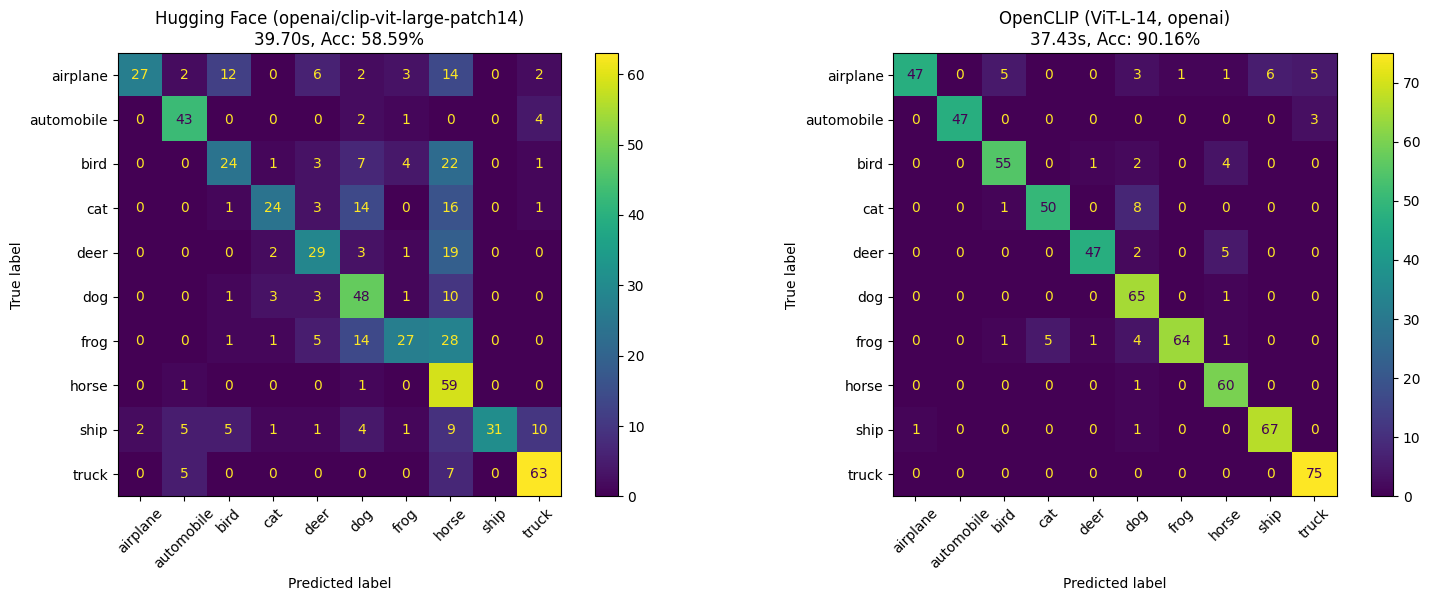

In [10]:
# Confusion matrices
cm_hf = confusion_matrix(y_true_hf, y_pred_hf)
cm_oc = confusion_matrix(y_true_oc, y_pred_oc)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ConfusionMatrixDisplay(cm_hf, display_labels=class_names).plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title(f"Hugging Face ({hf_model_key})\n{elapsed_hf:.2f}s, Acc: {acc_hf:.2f}%")

ConfusionMatrixDisplay(cm_oc, display_labels=class_names).plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title(f"OpenCLIP ({open_clip_trainmodel_name}, {open_clip_pretraining_name})\n{elapsed_oc:.2f}s, Acc: {acc_oc:.2f}%")

plt.tight_layout()

#save fig
plt.savefig("openclip_vs_huggingface.png", dpi=300, bbox_inches='tight')
plt.show()